In [1]:
CLUSTER_TYPE ='docker_cluster'
%env CLUSTER_TYPE $CLUSTER_TYPE
from dask.distributed import Client
client = Client('dask-scheduler:8786')
client

env: CLUSTER_TYPE=docker_cluster


<Client: 'tcp://172.22.0.2:8786' processes=4 threads=4, memory=3.81 GiB>

In [2]:
from time import time

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.dataframe as dd
from dask import compute
from dask import delayed
from dask.distributed import wait
import dask.bag as db

import dask_ml.datasets
import dask_ml.cluster

import sklearn as skl
import sklearn.cluster
##from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

# Utils

In [3]:
# %load dask_utils.py
import dask
import dask.array as da
import dask.dataframe as dd

#we want to work with dask array, hence we trasform everything to dask arrays
def make_da(X):
        if isinstance(X, dd.DataFrame):
            X = X.to_dask_array(lengths=True)
            
        if isinstance(X, da.core.Array): 
            return X
        
        else: raise ValueError("input is neither a dask array nor a dask dataframe")
        return X


# Scalable K-means: K-means||

### Obeservations:
- The centroids should be a numpy array stored in the machine. This way we can calculate distances without having to move data accross the nodes. This would have happened if the centroids array was distributed throughout the nodes.
- It should be optimized the way we compute the distances, as for now we are computing them multiple times but it would be smarter to keep track only of the min distance and the index of the closest centroid.
- This operation is just to shuffle the centroids in the order number of close data samples:  `centroids[centroid_index]`

 

In [4]:
# %load k-means.py
import dask
import numpy as np
import dask.array as da
import dask_ml

def get_random(p):
    x = np.random.random()
    return x < p

def OUR_pairwise_distances(X, centroids):
    '''
    def min_centroid(y):
        return da.sum(da.square(X - y), axis=1)
    return da.apply_along_axis(min_centroid, 1, centroids).T
    '''
    return dask_ml.metrics.pairwise_distances(X, centroids)

def evaluate_cost_and_dists(X, centroids): # (da.Array, np.array) -> float
    distances_matrix = OUR_pairwise_distances(X, centroids) 
    min_distances = da.min(distances_matrix, axis=1) 
    cost = min_distances.sum()
    return cost, da.power(min_distances,2)

def get_min_distances(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    return da.power(min_distances,2)

def get_closest_centroids_and_dists(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    closest_centroids = da.argmin(distances_matrix, axis=1)
    return closest_centroids, da.power(min_distances,2)
 
def oversample(X, distances, l):
    p = l * distances/distances.sum()
    return X[da.random.random(X.shape[0]) < p, :]

def k_means_pp_only_weights(c, counts, k): #explore alternatives
    p = counts/counts.sum()
    idx = np.arange(c.shape[0])
    final_index = np.random.choice(idx, size=k, replace=False, p=p)
    return c[final_index]

def k_means_pp_without_weights(c, weights, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_pp_weighted(c, weights, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        distances = distances * weights
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_scalable(X, k, l): 
    X = make_da(X)
    n = X.shape[0]
    idx = np.random.randint(0, n)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        centroids = np.vstack((centroids, new_centroids))
        distances = get_min_distances(X, centroids)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(a = len(X), size=(1, 3))
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    centroids_pp_w = k_means_pp_weighted(centroids, centroid_counts, k)
    centroids_pp = k_means_pp_without_weights(centroids, centroid_counts, k)
    return centroids, centroids_pp, centroids_pp_w #Return initial centroids for Lloyd's algorithm.

def k_means_scalable_opt(X, k, l): 
    X = make_da(X)
    n_points, n_features = X.shape
    idx = np.random.randint(0, n_points)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        if np.shape(new_centroids) == (0, n_features):
            continue
        new_distances = get_min_distances(X, new_centroids)
        centroids = np.vstack((centroids, new_centroids))
        distances = da.minimum(new_distances, distances)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(a = len(X), size=(1, 3))
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    centroids_pp = k_means_pp_weighted(centroids, centroid_counts, k)
    return centroids_pp #Return initial centroids for Lloyd's algorithm. 


## Test function

In [36]:
n_workers=len(client.scheduler_info()['workers'])
N=4000
n_feat=2
data, labels = dask_ml.datasets.make_blobs(N,n_features=n_feat ,centers=5, chunks=(N/n_workers,n_feat))
data.persist()

dask.array<concatenate, shape=(4000, 2), dtype=float64, chunksize=(1000, 2), chunktype=numpy.ndarray>

In [37]:
%time oversample_centroids, centroids_pp, centroids_pp_w = k_means_scalable(data, k=6, l=2)

CPU times: user 1.73 s, sys: 17.9 ms, total: 1.75 s
Wall time: 4.46 s


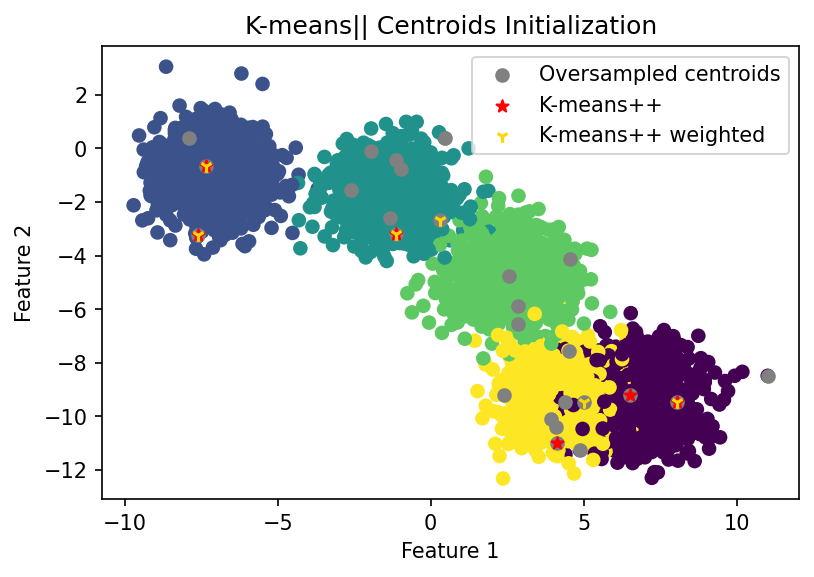

In [38]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(data[:,0], data[:,1], c= labels)
plt.scatter(oversample_centroids[:,0], oversample_centroids[:,1],c='grey', label="Oversampled centroids")
plt.scatter(centroids_pp[:,0], centroids_pp[:,1],c='red', marker="*",label="K-means++")
plt.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], marker='1', c='gold', label="K-means++ weighted")
plt.title("K-means|| Centroids Initialization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Scalable Lloyd's Algorithm

### Using Dask Arrays

In [5]:
# %load distributed_lloyd.py
import numpy as np
import dask
import dask.array as da
import dask_ml

def lloyd_scalable (X, k, centroids = None, maxIter = 1000, patience = 1e-8):
    X = make_da(X)
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = X[random_index[0]]
    n_features = X.shape[1]
    epoch = 1
    loss_diff = patience + 1
    loss = 0
    while (epoch < maxIter and loss_diff > patience):
        distances_matrix = dask_ml.metrics.pairwise_distances(X,
                np.array(centroids))
        indeces = da.argmin(distances_matrix, axis=1)
        new_loss = distances_matrix[indeces].sum()
        new_centroids = da.zeros((k, n_features))
        for i in range(indeces.max()):
            new_centroids[i] = X[indeces == i].mean(axis=0)
        epoch = epoch + 1
        loss_diff = da.absolute(new_loss - loss)
        centroids = new_centroids
        loss = new_loss
    return (centroids, indeces)


### Using Dask Dataframes

In [6]:
def lloyd_scalable_df(k, X, centroids = None, maxIter = 150, patience = 1e-7):
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = np.array(X[random_index[0]])
        
    closest_centroid = get_min_distances(X, centroids)[1]
    df=dd.from_array(da.hstack((X, closest_centroid[:,None])), chunksize=get_chunks(X))
    df=df.rename(columns={df.columns[-1]: 'closest_centroid'})
    dc=1 #fix this
    iteration=0
    while ((dc > patience) & (iteration< maxIter)):
        new_centroids= df.groupby('closest_centroid').mean().compute().to_numpy()
        x=df.drop('closest_centroid', axis=1).to_dask_array()
        df['closest_centroid'] = get_min_distances(x, centroids)[1]
        #dc= np.linalg.norm(new_centroids-centroids) #fix this
        centroids=new_centroids
        iteration +=1
    return centroids


In [ ]:
%time results, pred_labels = da.compute(*lloyd_scalable(data, k=5, centroids = centroids_pp_w, maxIter=150))

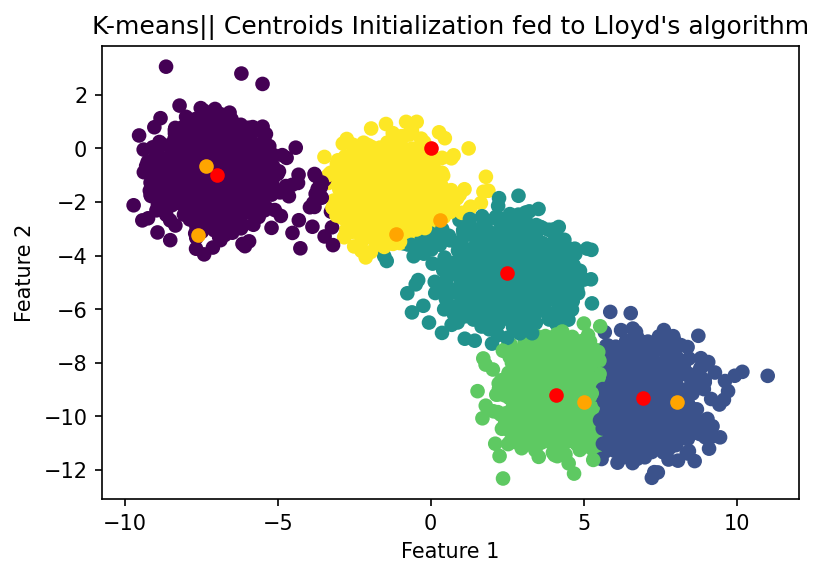

In [43]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(data[:,0], data[:,1], c=pred_labels)
plt.scatter(results[:,0], results[:,1],c='red')
plt.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1],c='orange')
plt.title("K-means|| Centroids Initialization fed to Lloyd's algorithm")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

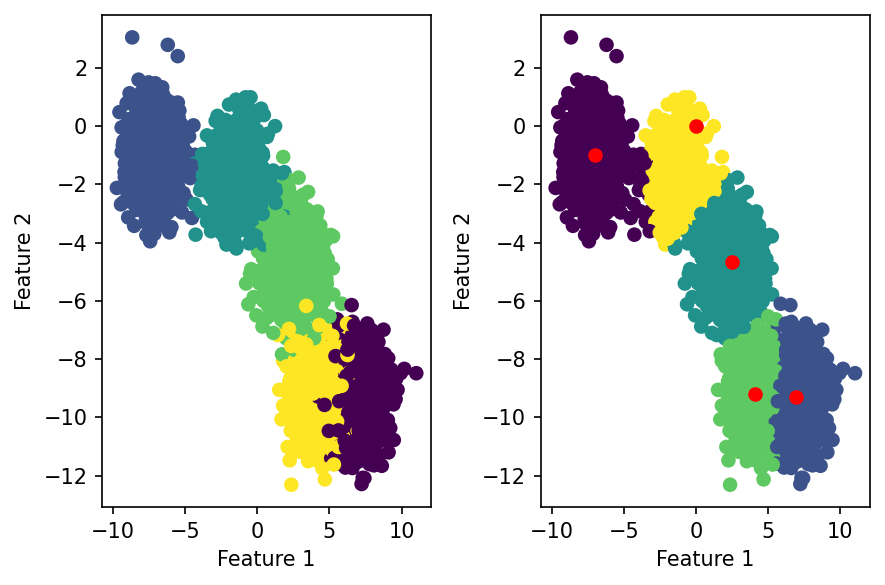

In [44]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[1].scatter(data[:,0], data[:,1], c=pred_labels)
ax[1].scatter(results[:,0], results[:,1],c='red')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
plt.tight_layout()
plt.show()

# Applying our Algorithm to the KDD Cup 1999 Data

This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ''bad'' connections, called intrusions or attacks, and ''good'' normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html


In [7]:
KDD_data  = dd.read_csv('./Datasets/KDD_features.csv') 
KDD_labels = dd.read_csv('./Datasets/KDD_labels.csv') 

Let's repartition the dask dataframe in a number of partitions proportional to the total number of avalaible workers.

In [8]:
n_workers=len(client.scheduler_info()['workers'])
partitions_per_worker=1
KDD_data=KDD_data.repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=KDD_labels.repartition(npartitions=n_workers*partitions_per_worker)
KDD_data=KDD_data.drop(columns='Unnamed: 0')

In particular we focused only on the data about the connection based on the http service.
The resulting dataset has the following classes:

In [9]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203
3,4
2,1
4,1


Hence we only focus on the two most frequent labels:0,1.

In [10]:
KDD_data=dd.concat([KDD_data[KDD_labels.labels == 0], KDD_data[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=dd.concat([KDD_labels[KDD_labels.labels == 0], KDD_labels[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)

In [11]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203


The features are the following:

In [12]:
KDD_data.columns

Index(['duration', 'src_bytes', 'dst_bytes'], dtype='object')

In [13]:
KDD_data.dtypes #checking that the inferred type are correct

duration     float64
src_bytes    float64
dst_bytes    float64
dtype: object

In [14]:
print('total number of samples:',len(KDD_data))

total number of samples: 58719


### Removing bad data

By exploring the dataset we found some values with src_bytes and dst_bytes with negative values. This is non sensical, hence we will filter out this noise.

In [15]:
KDD_labels=KDD_labels.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]
KDD_data=KDD_data.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]

Let's store the final version of the dataset in the nodes.

In [16]:
KDD_data.persist()
KDD_labels=KDD_labels.drop(columns='Unnamed: 0')
KDD_labels.persist()

,labels
npartitions=4,
,int64
,...
,...
,...
,...


Get a view:

In [17]:
KDD_data.head()

,duration,src_bytes,dst_bytes
132,1.131402,5.793318,5.861071
162,5.210032,5.752890,5.727173
175,1.808289,5.303802,4.852811
338,2.839078,5.820380,6.116113
580,0.095310,5.124559,8.738110


In [18]:
KDD_labels.head()

,labels
132,0
162,0
175,0
338,0
580,0


## Running K-means ||

In [19]:
%time oversample_centroids, centroids_pp, centroids_pp_w = k_means_scalable(KDD_data, k=2, l=2)

CPU times: user 1.83 s, sys: 22.5 ms, total: 1.85 s
Wall time: 16.5 s


In [20]:
%time results, pred_labels = da.compute(*lloyd_scalable(KDD_data, k=2, centroids = centroids_pp_w, maxIter=150))

CPU times: user 1.56 s, sys: 18.1 ms, total: 1.57 s
Wall time: 13.9 s


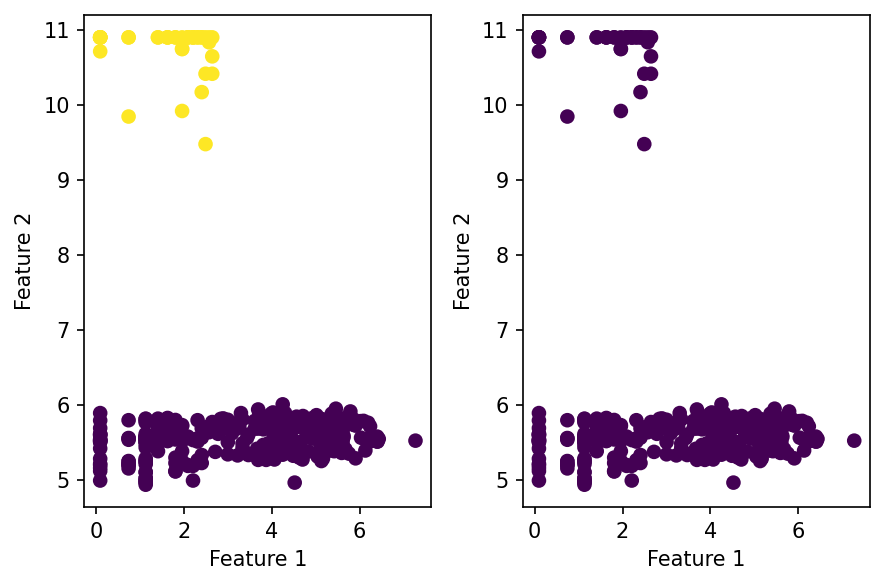

In [21]:
data=make_da(KDD_data)
labels=make_da(KDD_labels)
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[1].scatter(data[:,0], data[:,1], c=pred_labels)
ax[1].scatter(results[:,0], results[:,1],c='red')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
plt.tight_layout()
plt.show()

In [22]:
results

array([[0., 0., 0.],
       [0., 0., 0.]])

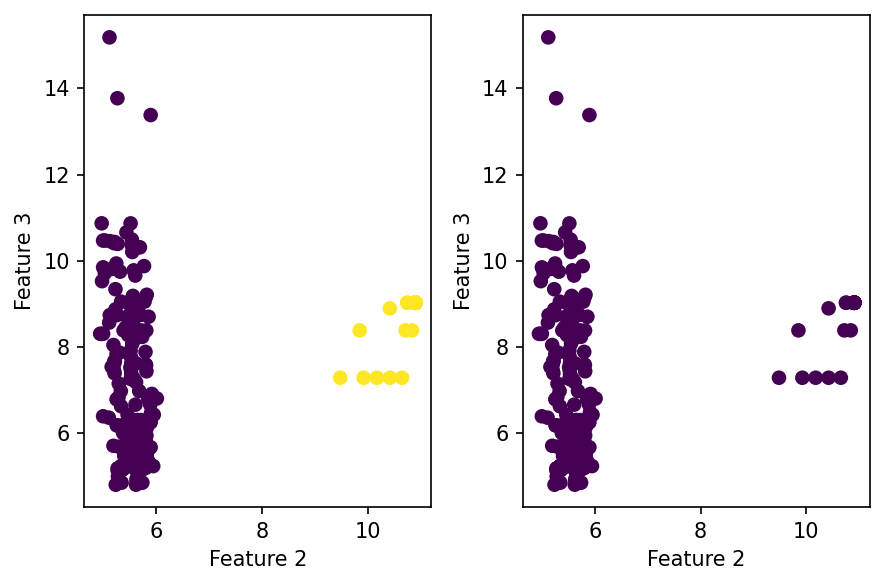

In [23]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,1], data[:,2], c=labels)
ax[1].scatter(data[:,1], data[:,2], c=pred_labels)
ax[1].scatter(results[:,1], results[:,2],c='red')
ax[0].set_xlabel('Feature 2')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 2')
ax[1].set_ylabel('Feature 3')
plt.tight_layout()
plt.show()

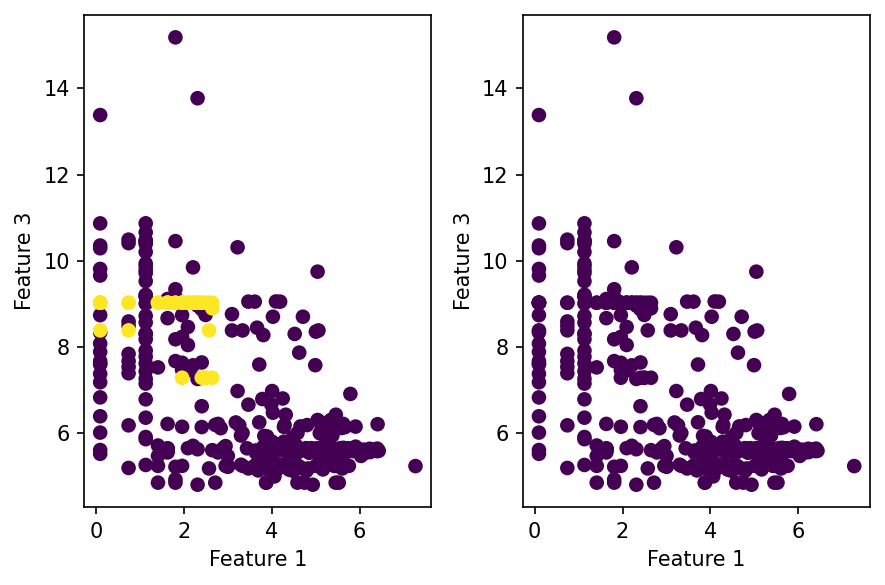

In [24]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,2], c=labels)
ax[1].scatter(data[:,0], data[:,2], c=pred_labels)
ax[1].scatter(results[:,0], results[:,2],c='red')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 3')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


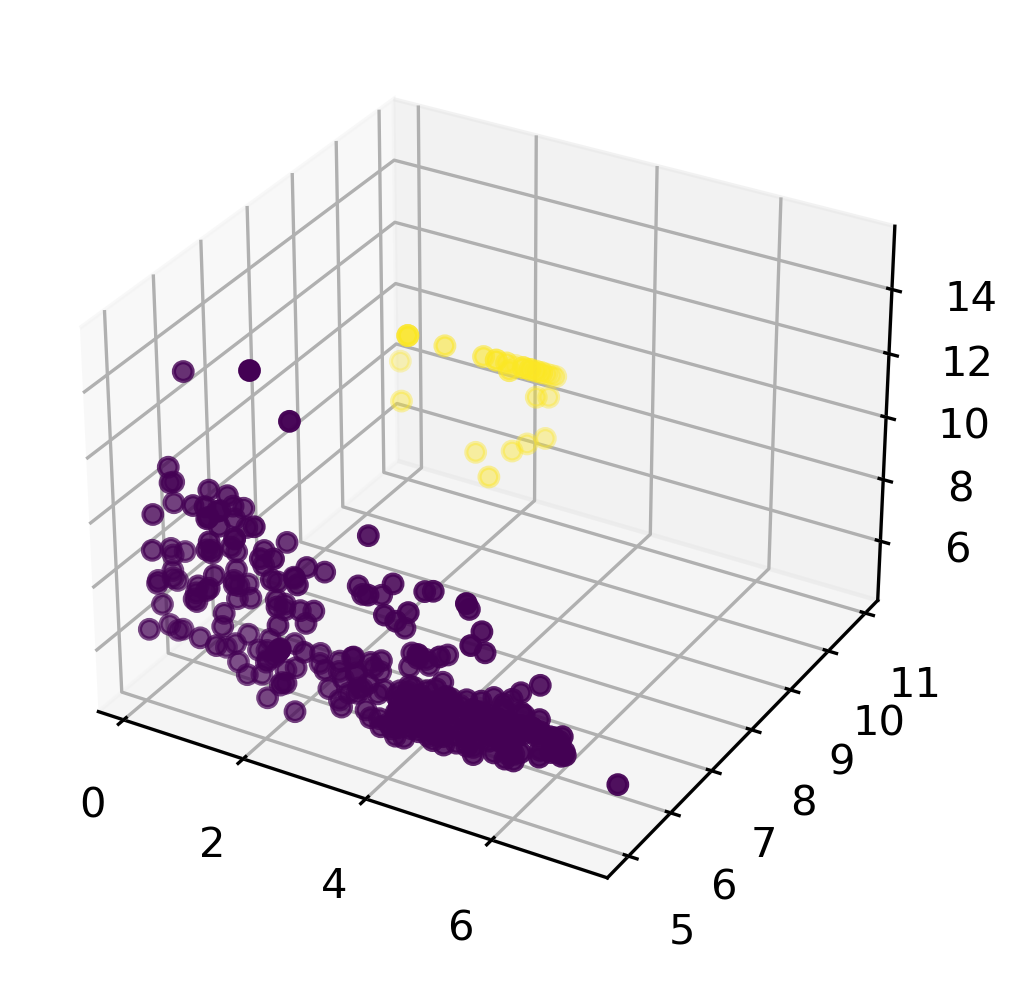

In [25]:
fig= plt.figure(dpi=300)
ax= fig.add_subplot(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=labels)

In [27]:
model = dask_ml.cluster.KMeans(n_clusters=2)
model.fit(KDD_data)
dask_pred_labels=model.predict(KDD_data)

/opt/conda/lib/python3.9/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


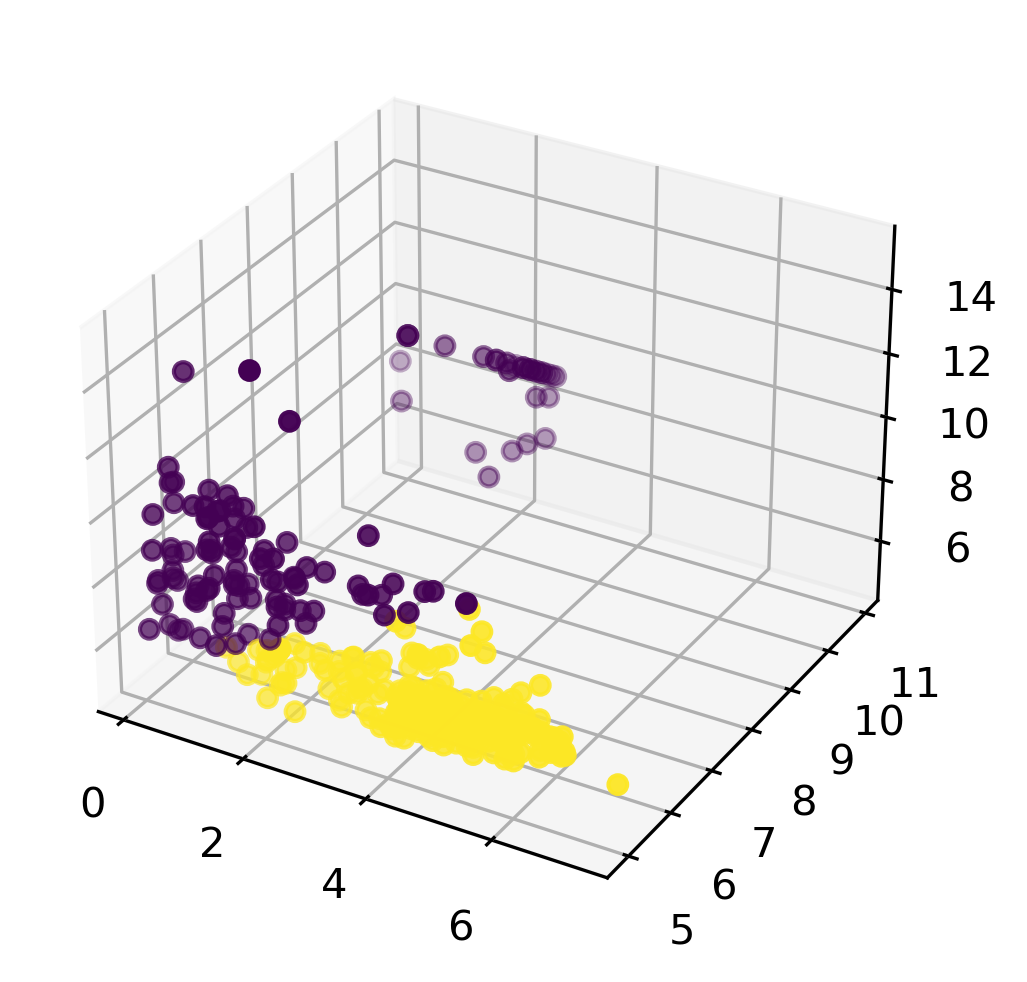

In [28]:
fig= plt.figure(dpi=300)
ax= fig.add_subplot(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=dask_pred_labels)